<a href="https://colab.research.google.com/github/marcinwolter/DNN_examples/blob/master/gan_generate_letters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


11501568/11490434 [==============================] - 2s 0us/step


W1119 12:10:19.447077 140575914035072 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1119 12:10:19.449713 140575914035072 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1119 12:10:19.453205 140575914035072 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1119 12:10:19.541758 140575914035072 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1119 12:10:19.743489 140575914035072 modu

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 784)               615440    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 392)               307720    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 392)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 393       
Total params: 923,553
Trainable params: 923,553
Non-trainable params: 0
_________________________________________________________________


W1119 12:10:20.082062 140575914035072 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1119 12:10:20.084840 140575914035072 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1119 12:10:20.086245 140575914035072 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1119 12:10:21.325882 140575914035072 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W1119 12:10:21.327888 140575914035072 module_wrapper.py:1

epoch: 0, [Discriminator :: d_loss: 0.751407], [ Generator :: loss: 1.008134]


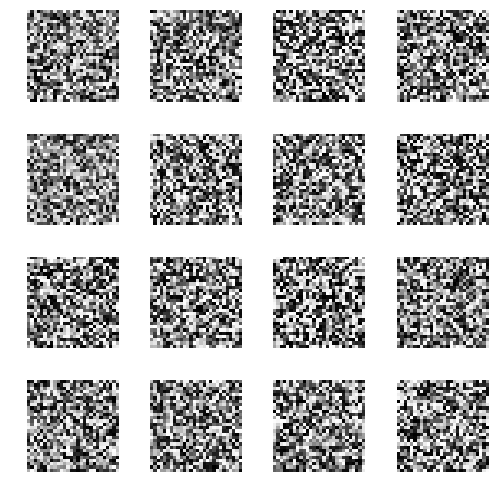

epoch: 100, [Discriminator :: d_loss: 0.013307], [ Generator :: loss: 5.084947]


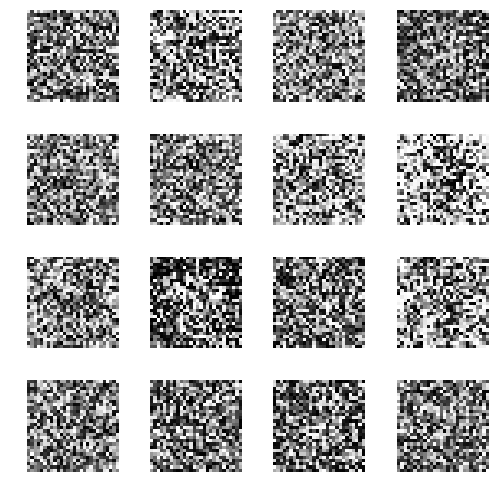

epoch: 200, [Discriminator :: d_loss: 0.260265], [ Generator :: loss: 2.877956]


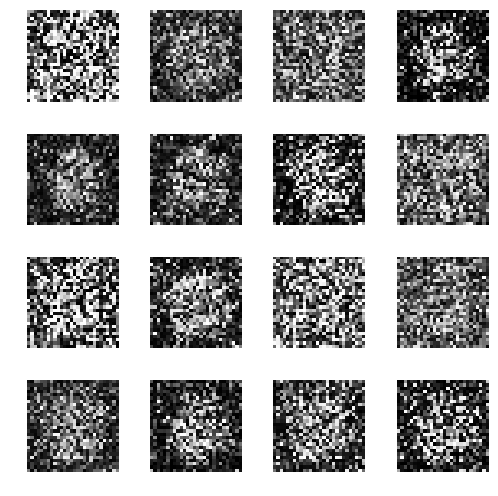

epoch: 300, [Discriminator :: d_loss: 0.566998], [ Generator :: loss: 0.858037]


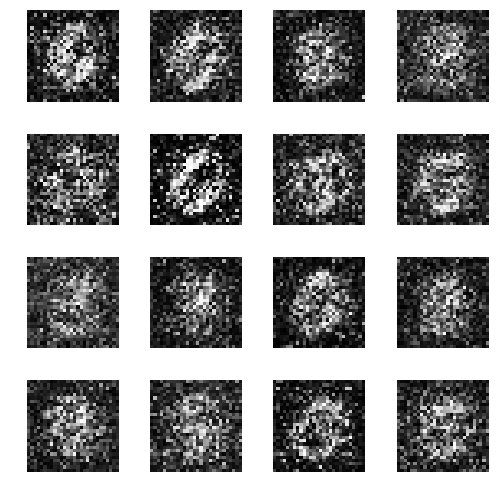

epoch: 400, [Discriminator :: d_loss: 0.683857], [ Generator :: loss: 0.581386]


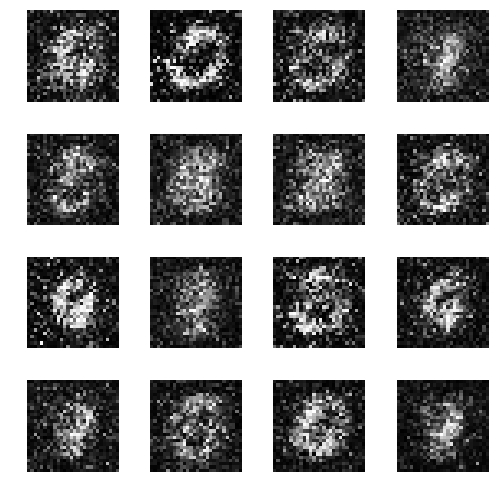

In [0]:
""" Simple implementation of Generative Adversarial Neural Network """

import numpy as np

#from IPython.core.debugger import Tracer

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam

import matplotlib.pyplot as plt
#plt.switch_backend('agg')   # allows code to run without a system DISPLAY


class GAN(object):
    """ Generative Adversarial Network class """
    def __init__(self, width=28, height=28, channels=1):

        self.width = width
        self.height = height
        self.channels = channels

        self.shape = (self.width, self.height, self.channels)

        self.optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

        self.G = self.__generator()
        self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)

        self.D = self.__discriminator()
        self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])

        self.stacked_generator_discriminator = self.__stacked_generator_discriminator()

        self.stacked_generator_discriminator.compile(loss='binary_crossentropy', optimizer=self.optimizer)


    def __generator(self):
        """ Declare generator """

        model = Sequential()
        model.add(Dense(256, input_shape=(100,)))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(self.width  * self.height * self.channels, activation='tanh'))
        model.add(Reshape((self.width, self.height, self.channels)))

        return model

    def __discriminator(self):
        """ Declare discriminator """

        model = Sequential()
        model.add(Flatten(input_shape=self.shape))
        model.add(Dense((self.width * self.height * self.channels), input_shape=self.shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense((self.width * self.height * self.channels)/2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        return model

    def __stacked_generator_discriminator(self):

        self.D.trainable = False

        model = Sequential()
        model.add(self.G)
        model.add(self.D)

        return model

    def train(self, X_train, epochs=20000, batch = 32, save_interval = 100):

        for cnt in range(epochs):

            ## train discriminator
            random_index = np.random.randint(0, len(X_train) - batch/2)
            legit_images = X_train[random_index : random_index + batch/2].reshape(batch/2, self.width, self.height, self.channels)

            gen_noise = np.random.normal(0, 1, (batch/2, 100))
            syntetic_images = self.G.predict(gen_noise)

            x_combined_batch = np.concatenate((legit_images, syntetic_images))
            y_combined_batch = np.concatenate((np.ones((batch/2, 1)), np.zeros((batch/2, 1))))

            d_loss = self.D.train_on_batch(x_combined_batch, y_combined_batch)


            # train generator

            noise = np.random.normal(0, 1, (batch, 100))
            y_mislabled = np.ones((batch, 1))

            g_loss = self.stacked_generator_discriminator.train_on_batch(noise, y_mislabled)

            if cnt % save_interval == 0:
                print ('epoch: %d, [Discriminator :: d_loss: %f], [ Generator :: loss: %f]' % (cnt, d_loss[0], g_loss))

            if cnt % save_interval == 0:
                self.plot_images(save2file=False, step=cnt)


    def plot_images(self, save2file=False, samples=16, step=0):
        ''' Plot generated images '''
        filename = "./mnist_%d.png" % step
        noise = np.random.normal(0, 1, (samples, 100))

        images = self.G.predict(noise)

        plt.figure(figsize=(7, 7))

        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.height, self.width])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()

        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()


if __name__ == '__main__':
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale -1 to 1
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)


    gan = GAN()
    gan.train(X_train)